In [1]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize

import cv2

In [2]:
# def set_axis(x, no_labels=7) -> tuple[np.array, np.array]:
#     """Sets the x-axis positions and labels for a plot.

#     Args:
#         x (np.array): The x-axis data.
#         no_labels (int, optional): The number of labels to display. Defaults to 7.

#     Returns:
#         tuple[np.array, np.array]: A tuple containing:
#             - The positions of the labels on the x-axis.
#             - The labels themselves.
#     """
#     nx = x.shape[0]
#     step_x = int(nx / (no_labels - 1))
#     x_positions = np.arange(0, nx, step_x)
#     x_labels = x[::step_x]
#     return x_positions, x_labels

In [16]:
path_out = "./data-mm/"
# path_out = "./Data/"
files = glob.glob(path_out + "*")
files.sort()

In [17]:
dx = 5.106500953873407
dt = 0.0016


data = []
first_filename = files[0]
for file in files:
    data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime(
    "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
)
index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

Dataframe's vizualization provided by the teacher:

In [18]:
# fig = plt.figure(figsize=(12, 16))
# ax = plt.axes()

# # This is an example transformation and should be converted to the proper algorithm
# df -= df.mean()
# df = np.abs(df)
# low, high = np.percentile(df, [3, 99])
# norm = Normalize(vmin=low, vmax=high, clip=True)

# im = ax.imshow(df, interpolation="none", aspect="auto", norm=norm)
# plt.ylabel("time")
# plt.xlabel("space [m]")

# cax = fig.add_axes(
#     [ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height]
# )
# plt.colorbar(im, cax=cax)
# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)
# plt.title("Martyn visualization")
# plt.show()

### Looking at how our dataframe looks like
Since we cannot see any information in here there is a need for the transformation; also we see that the size of it is quite large so we have decided to drop every second row of the dataframe


In [19]:
# fig = plt.figure(figsize=(3, 4))
# ax = plt.axes()
# im = ax.imshow(df, interpolation="none", aspect="auto")
# plt.ylabel("time")
# plt.xlabel("space [m]")

# cax = fig.add_axes(
#     [ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height]
# )
# plt.colorbar(im, cax=cax)
# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)
# plt.title("Raw dataframe, without preprocessing and norm")
# plt.show()

### Function for the vizualization of our dataframe


In [20]:
def visualize(dataframe,  size_x=3, size_y=4):

    fig = plt.figure(figsize=(size_x, size_y))
    ax = plt.axes()
# , norm = Normalize(vmin=low, vmax=high, clip=True)
    im = ax.imshow(
        dataframe, interpolation="none", aspect="auto", cmap="viridis"
    )
    plt.ylabel("time")
    plt.xlabel("space [m]")

    # Add colorbar
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.06,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    plt.colorbar(im, cax=cax)

    # Set axes labels
    x_positions, x_labels = set_axis(dataframe.columns)
    ax.set_xticks(x_positions, np.round(x_labels, 1))
    y_positions, y_labels = set_axis(dataframe.index.time)
    ax.set_yticks(y_positions, y_labels)

    plt.show()

In [21]:
def plot_dataframe_as_image(df, a=6, b=9):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=df.min().min(), vmax=df.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(df.values, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    # plt.colorbar(label='Value')
    plt.title('DataFrame Visualization')
    plt.axis('off')  # Turn off axis labels for better image representation
    
    # Display the plot
    plt.show()

### Our approach in basic preprocessing the data

In [22]:
# kernel_long = np.array([
#     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
#     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
# ])


# kernel_diag1 = np.array([
#     [-1,  0,  0,  0,  1],
#     [ 0, -1,  0,  1,  0],
#     [ 0,  0,  2,  0,  0],
#     [ 0,  1,  0, -1,  0],
#     [ 1,  0,  0,  0, -1]
# ])

# kernel_diag2 = np.array([
#     [ 1,  0,  0,  0, -1],
#     [ 0,  1,  0, -1,  0],
#     [ 0,  0,  2,  0,  0],
#     [ 0, -1,  0,  1,  0],
#     [-1,  0,  0,  0,  1]
# ])


# def detect_lines(df, kernel):
#     image_array = df.values.astype(np.float32)
#     result = cv2.filter2D(image_array, -1, kernel)
#     df_result = pd.DataFrame(result, columns=df.columns)
#     return df_result

# df_result_horizontal = detect_lines(df_gauss, kernel_horizontal)
# df_result_diag1 = detect_lines(df_gauss, kernel_diag1)
# df_result_diag2 = detect_lines(df_gauss, kernel_diag2)

# plot_dataframe_as_image(df_result_horizontal)
# plot_dataframe_as_image(df_result_diag1)
# plot_dataframe_as_image(df_result_diag2)


C:\Users\mary9\AppData\Local\Temp\ipykernel_27336\27855153.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.648617003160316e-06' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.clip(low, high, inplace=True)


percentile


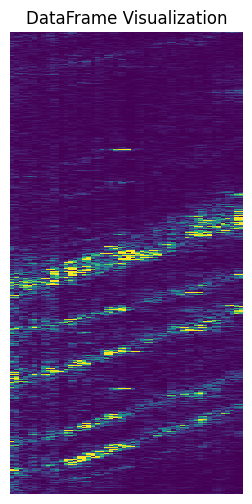

columnwise normalization


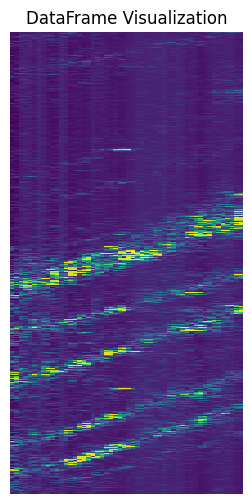

threshold below 40


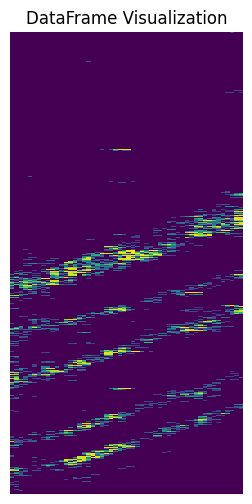

Result of denoising


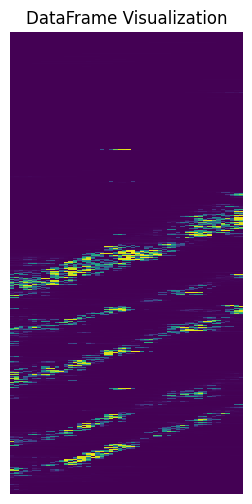

Gauss on 2nd denoise


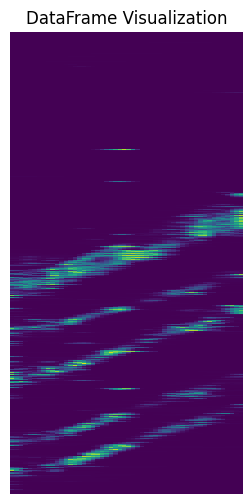

normalized background


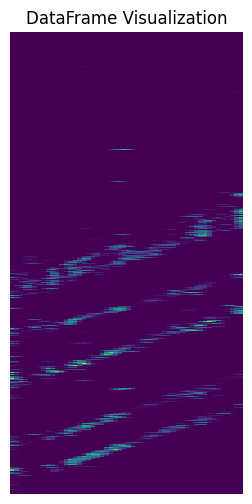

binarized after gauss


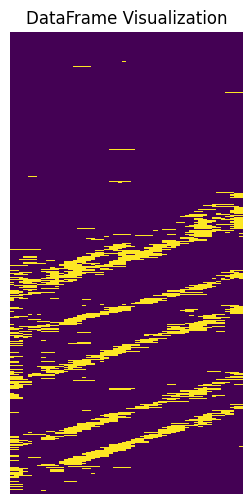

opening


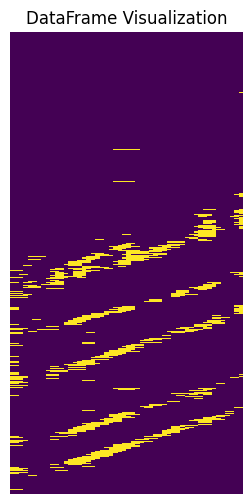

erosion


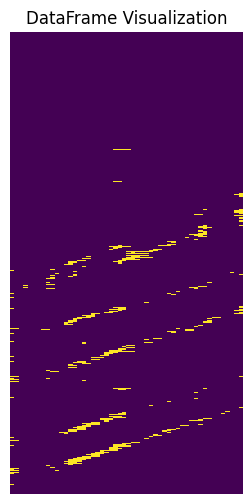

dilation


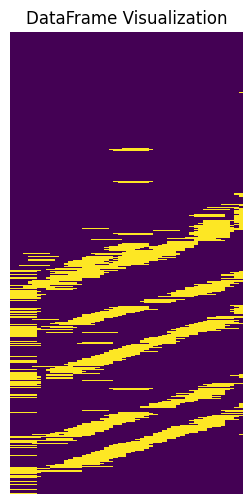

smooth edges


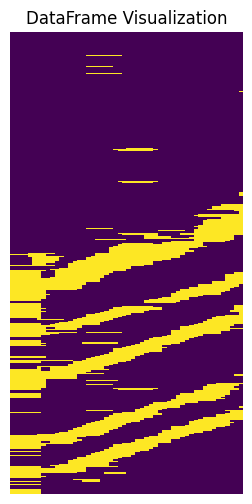

skeletonization


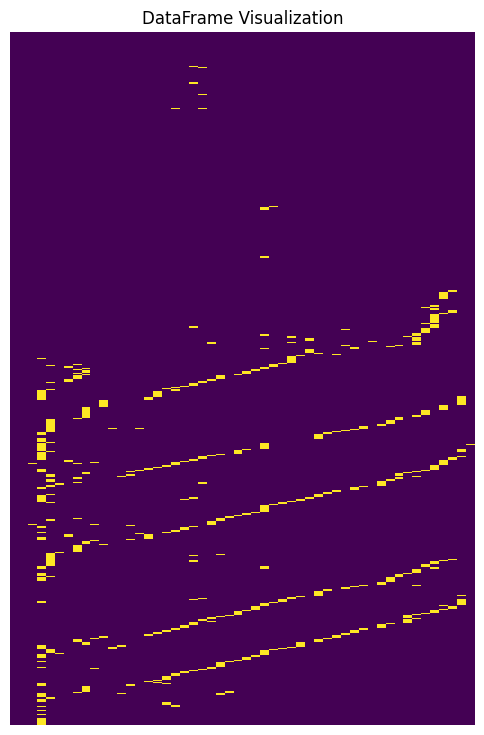

In [23]:
df = pd.DataFrame(data=data, index=index, columns=columns)

#ARITHMETIC OPERATIONS
# df = df.iloc[::2, :]  #cet every second row, its gonna be better for filters
df -= df.mean()
df = np.abs(df)

#CLIP PERCENTILES FOR OUTLIERS
low, high = np.percentile(df, [3,99])
# df[:] = df.apply(lambda col: np.where(((col < low)), low, col))
# df[:] = df.apply(lambda col: np.where(((col > high)), high, col))
df.clip(low, high, inplace=True)
print("percentile")
plot_dataframe_as_image(df, 3,6)

#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df_normalized = pd.DataFrame(normalized_image)
# print("normalized")
# plot_dataframe_as_image(df_normalized,3, 6)

df_normalized = df_normalized.apply(lambda x: x - x.mean())
print("columnwise normalization")
plot_dataframe_as_image(df_normalized,3, 6)
df_normalized[:] = df_normalized.apply(lambda col: np.where(((col < 40)), 0, col))
print("threshold below 40")
plot_dataframe_as_image(df_normalized,3, 6)


#NLM DENOISING
image = df_normalized.values.astype(np.uint8)
denoised_image2 = cv2.fastNlMeansDenoising(
    image,                      
    h=20,                       
    templateWindowSize=7,       
    searchWindowSize=21         
)
# df = pd.DataFrame(denoised_image, columns=df_normalized.columns)
print("Result of denoising")
# plot_dataframe_as_image(df, 3,6)
df2  = pd.DataFrame(denoised_image2, columns=df_normalized.columns)
plot_dataframe_as_image(df2, 3,6)





# #GAUSSIAN ON 3,21 KERNEL
# kernel = (3,21)
# df_gauss = pd.DataFrame(cv2.GaussianBlur(df.values.astype(np.float32), kernel, 3), columns = df.columns)
# print("Gauss")
# plot_dataframe_as_image(df_gauss,3,6)

kernel = (3,21)
df_gauss = pd.DataFrame(cv2.GaussianBlur(df2.values.astype(np.float32), kernel, 3), columns = df.columns)
print("Gauss on 2nd denoise")
plot_dataframe_as_image(df_gauss,3,6)



# #COMBINE EDGES WITH BACKGROUND SUBSTRACTION
# edges = cv2.Canny(df_gauss.values.astype(np.uint8), 100, 200)
# foreground = cv2.bitwise_and(df_gauss.values.astype(np.uint8), df_gauss.values.astype(np.uint8), mask=edges)
# background = cv2.GaussianBlur(df_gauss.values.astype(np.uint8), (21, 21), 0)
# normalized_background = cv2.subtract(df_gauss.values.astype(np.uint8), background)
# normalized_background = cv2.normalize(normalized_background, None, 0, 255, cv2.NORM_MINMAX)
# final_result = cv2.add(foreground, normalized_background)
# print("EDGES AND BACKGROUND")
# plot_dataframe_as_image(pd.DataFrame(final_result, columns = df.columns))


#THIS IS NICE. IT REMOVES GAUSSIAN-BACKGROUND BLUR, AND THEN IT APPLIES MORE CONTRAST
background = cv2.GaussianBlur(df_gauss.values.astype(np.uint8), (21,21), 0)
normalized_image = cv2.subtract(df_gauss.values.astype(np.uint8), background)
normalized_image = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX)
print("normalized background")
df_norm = pd.DataFrame(normalized_image, columns = df.columns)
plot_dataframe_as_image(df_norm,3,6)


#EQUALIZE
# clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
# equalized_image = clahe.apply(normalized_image)
# df_equalized = pd.DataFrame(equalized_image, columns = df.columns)
# print("equalized_image")
# plot_dataframe_as_image(df_equalized,3,6)


# df_equalized[:] = df_equalized.apply(lambda col: np.where(((col < 90)), 0, col))
# plot_dataframe_as_image(df_equalized,3,6)



# can = cv2.Canny(equalized_image, 50, 150)
# print("Canny")
# plot_dataframe_as_image(pd.DataFrame(can, columns = df.columns))



#BINARIZATION
df_binarized = (df_norm > np.percentile(df_norm, 90)).astype(int)
print("binarized after gauss")
plot_dataframe_as_image(df_binarized,3,6)


#OPENING FOR NOISE REDUCTION
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,20))
opening = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_OPEN, kernel )
print("opening")
plot_dataframe_as_image(pd.DataFrame(opening),3,6)



# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_image, connectivity=8)
# filtered_image = np.zeros_like(closed_image)
# for label in range(1, num_labels):
#     component = (labels == label).astype(np.uint8)
#     x, y, w, h, area = stats[label]
#     if w >= 3:
#         filtered_image[component == 1] = 1

# print("filtered")
# # plot_dataframe_as_image(pd.DataFrame(filtered_image, columns = df.columns))




#EROSION, 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,15))
eroded_image = cv2.erode(df_binarized.values.astype(np.uint8), kernel, iterations=1)
df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
print("erosion")
plot_dataframe_as_image(df_eroded,3,6)


# #FILTERING FOR LONE PIXELS
# binary_image = df_eroded.values.astype(np.uint8)
# kernel = np.ones((3000, 7), dtype=np.uint8)
# neighborhood_count = cv2.filter2D(binary_image, -1, kernel, borderType=cv2.BORDER_CONSTANT)
# threshold = 250  # Maximum allowed 1's in the neighborhood
# filtered_image = np.where(neighborhood_count < threshold, binary_image, 0)
# df_filtered = pd.DataFrame(filtered_image, index=df_eroded.index, columns=df_eroded.columns)
# print("filtered for lone pixels")
# plot_dataframe_as_image(df_filtered,3,6)

# rows, cols = 70000, 52
# krowa = pd.DataFrame(np.zeros((rows, cols), dtype=int))
# krowa.iloc[1000:4000, 0:7] = 1
# print("filtered for lone pixels")
# plot_dataframe_as_image(krowa,3,6)

#DILATION
kernel_diagonal = np.ones((10, 2), dtype=np.uint8)
# for i in range(20):
#     kernel_diagonal[i, min(i, 4)] = 1
kernel_flip =  np.flip(kernel_diagonal,axis=1 )
# print(kernel_flip)
img_bin_dil = cv2.dilate(df_eroded.values.astype(np.uint8), kernel_flip, iterations=5)   #i have like 20 pixels gaps on vertical. 
df_dilated = pd.DataFrame(img_bin_dil, columns=df.columns)
print("dilation")
plot_dataframe_as_image(df_dilated,3,6)





# CLOSE VERTICAL
vertical_kernel = np.ones((300, 2), dtype=np.uint8)
closed_image = cv2.morphologyEx(df_dilated.values.astype(np.uint8), cv2.MORPH_CLOSE, vertical_kernel)
print("smooth edges")
df_smooth = pd.DataFrame(closed_image, columns = df.columns)
plot_dataframe_as_image(df_smooth,3,6)


# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
# eroded_image = cv2.erode(closed_image, kernel, iterations=10)
# df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
# print("erosion on closed regions")
# plot_dataframe_as_image(df_eroded,3,6)




# df_eroded = df_eroded.iloc[::2, :]  #cet every second row, its gonna be better for filters
# print("df_second")
# plot_dataframe_as_image(df_eroded,3,6)






#SKELETONIZATION
def skeletonize(img):
    s1 = np.array([[-1, -1, -1], 
                   [0, 1, 0], 
                   [1, 1, 1]], dtype = np.int8)
    s2 = np.array([[0, -1, -1], 
                   [1, 1, -1], 
                   [0, 1, 0]], dtype = np.int8)
    skeleton = np.copy(img)
    
    change = True
    while change:
        change = False
        for i in range(4):
            thin1 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s1)
            thin1 = np.logical_and(skeleton, np.logical_not(thin1))
            if not np.array_equal(thin1, skeleton):
                change = True
            skeleton = thin1
            
            thin2 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s2)
            thin2 = np.logical_and(skeleton, np.logical_not(thin2))
            if not np.array_equal(thin2, skeleton):
                change = True
            skeleton = thin2
                        
            s1 = np.rot90(s1)
            s2 = np.rot90(s2)
        
    
    return skeleton

print("skeletonization")
skeleton = pd.DataFrame(skeletonize(df_smooth.values), columns = df.columns)
plot_dataframe_as_image(skeleton)

8


NameError: name 'set_axis' is not defined

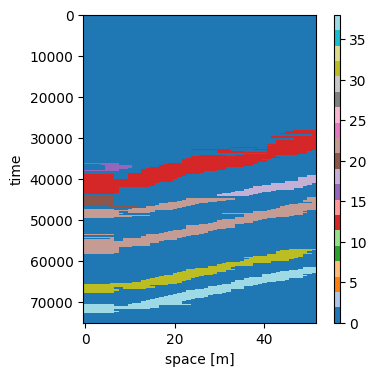

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from skimage.measure import label, regionprops

# Assuming df_dilated is your binary image DataFrame
binary_image = df_smooth.values.astype(np.uint8)  # Convert DataFrame to uint8 numpy array

# Perform connected components analysis
num_labels, labels = cv2.connectedComponents(binary_image)

# Create a copy of labels with components smaller than 50 pixels removed
filtered_labels = np.zeros_like(labels)
krowa=0
for label_idx in range(1, num_labels):  # Start from 1 to skip background
    # Create a mask for the current component
    component_mask = (labels == label_idx)
    
    # Calculate the area of the component
    area = np.sum(component_mask)
    
    # Include components larger than 50 pixels in the filtered labels
    if area > 10000:
        krowa +=1
        filtered_labels[component_mask] = label_idx
print(krowa)
# Visualize the filtered labeled regions
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

# Use the filtered labels for visualization
im = ax.imshow(filtered_labels, interpolation='none', aspect='auto', cmap='tab20')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add a colorbar to indicate label values
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

# Adjust x and y axis ticks if necessary (example assumes set_axis functions are defined)
x_positions, x_labels = set_axis(df_dilated.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df_dilated.index)
ax.set_yticks(y_positions, y_labels)

plt.show()


(244, 1, 4)


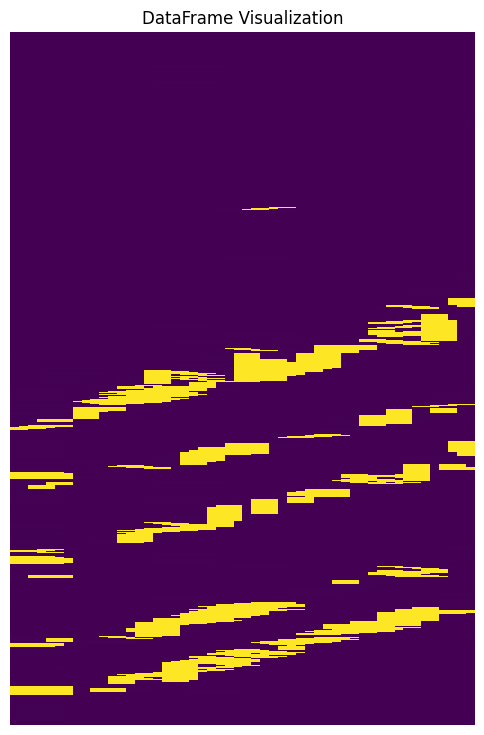

In [27]:
binary_image = df_dilated.values.astype(np.uint8)  # Convert DataFrame to uint8 array

lines = cv2.HoughLinesP(
    binary_image,
    rho=1,
    theta=np.pi / 180,
    threshold=50,
    minLineLength=300,
    maxLineGap=10,
)
print(lines.shape)
output_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# Draw the detected lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract line coordinates
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 255, 255), 2)  # Draw with green color

output_df = pd.DataFrame(output_image[:, :, 0]) 
plot_dataframe_as_image(output_df)

# fig = plt.figure(figsize=(12, 16))
# ax = plt.axes()

# im = ax.imshow(lines, interpolation="none", aspect="auto")
# plt.ylabel("time")
# plt.xlabel("space [m]")

# cax = fig.add_axes(
#     [ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height]
# )
# plt.colorbar(im, cax=cax)
# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)
# plt.title("Martyn visualization")
# plt.show()


# def visualize_hough_lines(binary_image, lines, size_x=8, size_y=6, scale_factor=0.01):
# """
#     Visualizes the output of Hough Line Detection on a binary image.

#     Parameters:
#     binary_image (np.ndarray): The input binary image for line detection.
#     lines (list): Detected lines from HoughLinesP.
#     size_x, size_y (int): Dimensions of the output plot.
#     scale_factor (float): Factor to resize the image for visualization.
#     """
#     # Resize binary image for large dimensions
#     resized_binary = cv2.resize(
#         binary_image.astype(np.uint8),
#         (int(binary_image.shape[1] * scale_factor), int(binary_image.shape[0] * scale_factor)),
#         interpolation=cv2.INTER_AREA,
#     )

#     # Convert resized binary image to a color image for line overlay
#     output_image = cv2.cvtColor(resized_binary * 255, cv2.COLOR_GRAY2BGR)

#     # Draw the detected lines
#     if lines is not None:
#         for line in lines:
#             x1, y1, x2, y2 = line[0]
#             x1, y1, x2, y2 = (
#                 int(x1 * scale_factor),
#                 int(y1 * scale_factor),
#                 int(x2 * scale_factor),
#                 int(y2 * scale_factor),
#             )
#             cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

#     # Plot the result
#     plt.figure(figsize=(size_x, size_y))
#     plt.imshow(output_image)
#     plt.axis("off")
#     plt.title("Detected Lines")
#     plt.show()


# visualize_hough_lines(binary_image, lines, size_x=6, size_y=4, scale_factor=0.01)

From the shape we see that we migh get rid of every second row of the picture

In [ ]:
#THIS IS WHATEVER YOU DID BEFORE I SAT DOWN TO IT

# df[:] = df.apply(lambda col: np.where((col < low), 0, col))


# # Apply Fourier Transform to the data along the spatial dimension (columns).
# # This transforms the data from the spatial domain into the frequency domain.
# df_fft = np.fft.fft(df, axis=0)

# # Remove low frequencies (which correspond to smoother, slower changes over space).
# # This acts as a high-pass filter, removing smooth trends and keeping sharper, rapid variations.
# # The `[:10]` selects the first 10 frequency components and sets them to 0.
# df_fft[:10] = 0

# # Apply the inverse Fourier Transform to convert the data back to the spatial domain.
# # Only the high-frequency components remain after this step.
# # The `.real` extracts the real part of the complex values resulting from the inverse transform.
# df_filtered = np.fft.ifft(df_fft, axis=0).real

# # Reconstruct the DataFrame with the filtered data, preserving the original indexing and column labels.
# df = pd.DataFrame(df_filtered, index=df.index, columns=df.columns)

# # Step 2: Signal Magnitude Enhancement
# # Compute the Root Mean Square (RMS) value for the data.
# # This emphasizes the magnitude of changes and ensures all values are non-negative.
# df = np.sqrt(df**2)

# # Step 3: Edge Detection
# # Use the Sobel filter from the `skimage.filters` library for edge detection.
# # Sobel calculates the gradient of the data, which highlights transitions (edges) in the signal.
# # This is particularly useful for identifying boundaries or rapid changes in the data.
# from skimage.filters import sobel
# df_edges = sobel(df.values)

# # Convert the result back to a DataFrame for consistency with the original data structure.
# df = pd.DataFrame(df_edges, index=df.index, columns=df.columns)

# # Step 4: Normalize Data for Visualization
# # Calculate the 3rd and 99th percentiles of the data to define a robust range for normalization.
# # This prevents outliers from dominating the contrast in the visualization.
# low, high = np.percentile(df, [3, 99])

# # Create a normalization object to scale the data for visualization.
# # The data will be clipped and scaled to the range [low, high].
# from matplotlib.colors import Normalize
# norm = Normalize(vmin=low, vmax=high, clip=True)

# # The normalized data is now ready for visualization.

In [ ]:
# df_reduced = df.iloc[::2, :]
# print(df_reduced.shape)

# visualize(df_reduced)


In [ ]:
# # Perform Fourier transform along the spatial dimension (columns)
# df_fft = np.fft.fft(df_reduced, axis=1)

# # Create a low-pass filter mask
# num_cols = df_reduced.shape[1]
# freq_cutoff = int(num_cols * 0.1)  # Retain 10% of low frequencies
# low_pass_mask = np.zeros_like(df_fft)
# low_pass_mask[:, :freq_cutoff] = 1  # Retain only the first few frequencies
# low_pass_mask[:, -freq_cutoff:] = 1  # Symmetric frequencies

# # Apply the low-pass filter
# df_fft_filtered = df_fft * low_pass_mask

# # Perform inverse Fourier transform to return to spatial domain
# df_filtered = np.fft.ifft(df_fft_filtered, axis=1).real

# # Convert back to DataFrame
# df_filtered = pd.DataFrame(df_filtered, index=df_reduced.index, columns=df_reduced.columns)


In [ ]:
# visualize(df_filtered)

In [ ]:
# import cv2
# import numpy as np

# # Apply Gaussian blur
# df_blurred = cv2.GaussianBlur(df.values, (5, 5), 0)  # (5, 5) is the kernel size; adjust as needed
# df = pd.DataFrame(df_blurred, index=df.index, columns=df.columns)

# # Re-visualize after Gaussian blur
# fig = plt.figure(figsize=(3, 4))
# ax = plt.axes()

# im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap='viridis')
# plt.ylabel('time')
# plt.xlabel('space [m]')

# # Add colorbar
# cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(im, cax=cax)

# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels, 1))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)

# plt.show()


## Binary tresholding
Threshold the smoothed data to create a binary mask for detecting significant signal regions.

In [ ]:
# df

In [ ]:
# data = df.values

In [ ]:
# from skimage.filters import threshold_otsu

# # Apply Otsu's thresholding
# # thresh = threshold_otsu(df.values)
# # binary_mask = df.values > thresh


# binary_mask = data > np.percentile(data, 80)

# # Visualize the binary mask
# fig = plt.figure(figsize=(3, 4))
# ax = plt.axes()

# im = ax.imshow(binary_mask, interpolation='none', aspect='auto', cmap='gray')
# plt.ylabel('time')
# plt.xlabel('space [m]')

# # Add colorbar
# cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(im, cax=cax)

# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels, 1))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)

# plt.show()


In [ ]:
# binary_mask[binary_mask.nonzero()] = 1 
# binary_mask

## Connecting fragments using Morphological operations
Small gaps in objects can be connected using morphological operations like dilation and closing. This is especially useful after thresholding to fix fragmented objects.

In [ ]:
# from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk

# # Define a structuring element
# kernel = np.array([
#     [0,0,1],
#     [0,1,0],
#     [1,0,0]], np.uint8) # You can adjust the size of the structuring element as needed

# # Apply morphological operations
# # binary_dilated = binary_dilation(binary_mask, kernel)

# closing = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

# # binary_eroded = binary_erosion(binary_mask, kernel)
# # binary_opened = binary_opening(binary_mask, kernel, iterations=2)
# # binary_closed = binary_closing(binary_opened, kernel)
# # dilated2 = binary_dilation(binary_closed, kernel)

# # Visualize the result after morphological operations
# fig = plt.figure(figsize=(3, 4))
# ax = plt.axes()

# im = ax.imshow(closing, interpolation='none', aspect='auto', cmap='gray')
# plt.ylabel('time')
# plt.xlabel('space [m]')

# # Add colorbar
# cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
# plt.colorbar(im, cax=cax)

# x_positions, x_labels = set_axis(df.columns)
# ax.set_xticks(x_positions, np.round(x_labels, 1))
# y_positions, y_labels = set_axis(df.index.time)
# ax.set_yticks(y_positions, y_labels)

# plt.show()

## Object Detection (Labeling)
Label connected regions in the binary mask to detect individual objects (slanted lines).

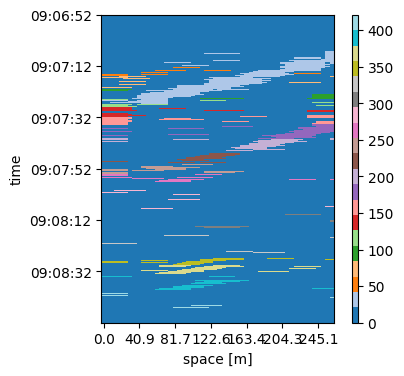

In [ ]:
from skimage.measure import label, regionprops

# Label connected regions in the binary mask
labels = label(df_dilated.values)

# Extract region properties for detected objects
regions = regionprops(labels)

# Visualize labeled regions
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(labels, interpolation='none', aspect='auto', cmap='tab20')
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)


x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Calculate Velocities
For each detected object (region), calculate velocity based on the slope of the slanted line.

Extract Bounding Boxes or Orientation: Use regionprops to get the bounding box or orientation of each object.

Calculate Velocity: Velocity is determined as:

v = \frac{\Delta x}{\Delta t} = \frac{\text{dx} \cdot (\text{end_col} - \text{start_col})}{\text{dt} \cdot (\text{end_row} - \text{start_row})}

In [ ]:
dx = 5.106500953873407  # Spatial resolution (meters)
dt = 0.0016  # Temporal resolution (seconds)
min_size = 50  # Minimum region size (rows)

velocities = []
for region in regions:
    min_row, min_col, max_row, max_col = region.bbox
    delta_space = (max_col - min_col) * dx
    delta_time = (max_row - min_row) * dt

    # Compute velocity only for valid and sufficiently large regions
    if delta_time > 0 and (max_row - min_row) >= min_size:
        velocity = delta_space / delta_time
        velocities.append(velocity)
    else:
        velocities.append(0)  # Assign zero velocity for invalid cases

print("Corrected Object Velocities (m/s):", sorted(velocities))


Corrected Object Velocities (m/s): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.88519262429237, 16.451356165829274, 17.78855418209501, 29.423304031944117, 29.49082943073708, 32.75797899295625, 33.39453164902265, 37.99479876393904, 39.96590639212192, 41.810870255513706, 41.99425126540631, 44.951592903815204, 45.014994304243714, 45.63722253819179, 49.04293173785039, 49.10097071032122, 50.081589240912514, 52.13755349637376, 52.14972379364182, 55.02694993398068, 55.02694993398068, 55.40908153074443, 55.992335020541745, 56.99219814590857, 56.99219814590857, 57.609442169149446, 59.10302029946073, 60.21817162586565, 61.37621338790152, 61.37621338790152, 61.37621338790152, 62.0581713144337

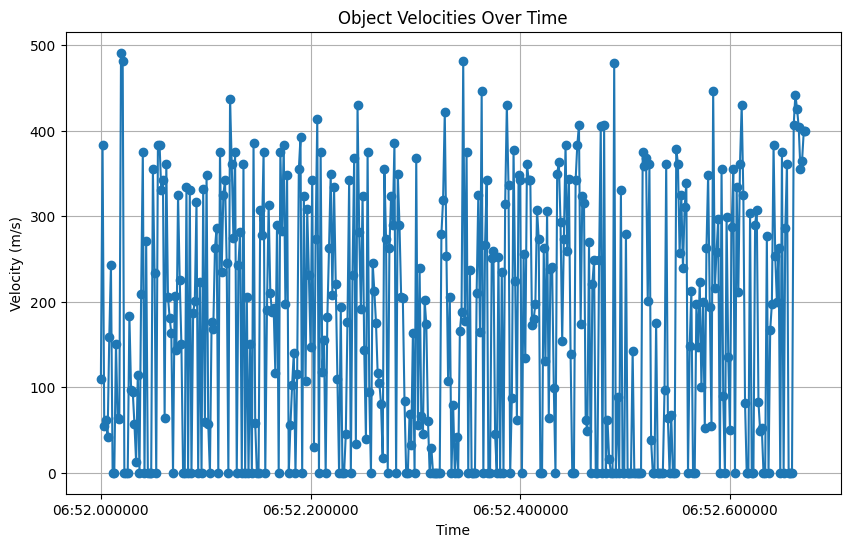

In [ ]:
# Plot velocities
import matplotlib.pyplot as plt

time = df.index[:len(velocities)]  # Assuming velocities correspond to time slices
plt.figure(figsize=(10, 6))
plt.plot(time, velocities, marker='o')
plt.title("Object Velocities Over Time")
plt.xlabel("Time")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.show()
